In [1]:
import torch
import torch_directml

In [2]:
gpu = torch_directml.device()

In [3]:
gpu

device(type='privateuseone', index=0)

In [4]:
t1 = torch.tensor([1]).to(gpu)
t2 = torch.tensor([2]).to(gpu)

In [5]:
calc = t1 + t2
calc.item()

3

In [6]:
t1.get_device()

0

# Examples

https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e#dc96

## Linear Regression

In [7]:
import numpy as np

In [8]:
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + 0.1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses remainder for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

### First Using Numpy Only

In [9]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)
print(a, b)

[0.49671415] [-0.1382643]


In [10]:
# Set Learning Rate and Epochs
lr = 1e-1
n_epochs = 1000

for epoch in range(n_epochs):
    # Compute predicted output
    yhat = a + b * x_train

    # Computes Loss (MSE)
    error = (y_train - yhat)
    loss = (error ** 2).mean()

    # Computes gradients for a and b parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()

    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad

print(a, b)

[1.02354094] [1.96896411]


In [11]:
# Sanity Check: do we get the same results as our manual calc?
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train, y_train)
print(lm.intercept_, lm.coef_[0])

[1.02354075] [1.96896447]


### Torching It

In [12]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

In [13]:
# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(gpu)
y_train_tensor = torch.from_numpy(y_train).float().to(gpu)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train),
      type(x_train_tensor),
      x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.privateuseone.FloatTensor


In [14]:
# FIRST
# Initializes parameters "a" and "b" randomly, ALMOST as we did in Numpy
# since we want to apply gradient descent on these parameters, we need
# to set REQUIRES_GRAD = TRUE
a = torch.randn(1, requires_grad = True, dtype = torch.float)
b = torch.randn(1, requires_grad = True, dtype = torch.float)
print(a, b)

# SECOND
# But what if we want to run it on a GPU? We could just send them to device, right?
a = torch.randn(1, requires_grad = True, dtype = torch.float).to(gpu)
b = torch.randn(1, requires_grad = True, dtype = torch.float).to(gpu)
print(a, b)

# THIRD
# We can either create regular tensors and send them to the device (as we did with our data)
a = torch.randn(1, dtype = torch.float).to(gpu)
b = torch.randn(1, dtype = torch.float).to(gpu)
# and THEN set them as requiring gradients
a.requires_grad_()
b.requires_grad_()
print(a, b)

# In PyTorch, every method that ends with an underscore (_) makes changes in-place, meaning, they will modify the underlying variable.

tensor([-1.0547], requires_grad=True) tensor([-0.1390], requires_grad=True)
tensor([-0.3408], device='privateuseone:0', grad_fn=<ToCopyBackward0>) tensor([-1.1771], device='privateuseone:0', grad_fn=<ToCopyBackward0>)
tensor([-0.8199], device='privateuseone:0', requires_grad=True) tensor([-1.9425], device='privateuseone:0', requires_grad=True)


In [20]:
# We can specify the device at the moment of creation - RECOMMENDED!
torch.manual_seed(42)
a = torch.randn(1, requires_grad = True, dtype = torch.float, device = gpu)
b = torch.randn(1, requires_grad = True, dtype = torch.float, device = gpu)
print(a, b)

tensor([0.3367], device='privateuseone:0', requires_grad=True) tensor([0.1288], device='privateuseone:0', requires_grad=True)


In [23]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad = True, dtype = torch.float, device = gpu)
b = torch.randn(1, requires_grad = True, dtype = torch.float, device = gpu)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()

    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad

    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()

print(a, b)

tensor([1.0235], device='privateuseone:0', requires_grad=True) tensor([1.9690], device='privateuseone:0', requires_grad=True)


### Dynamic Computation Graph

In [27]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad = True, dtype = torch.float, device = gpu)
b = torch.randn(1, requires_grad = True, dtype = torch.float, device = gpu)

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()

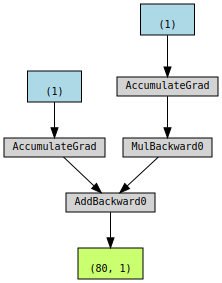

In [30]:
make_dot(yhat)

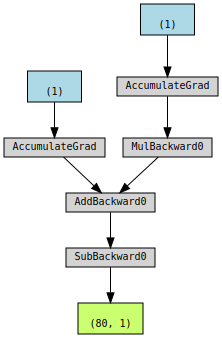

In [31]:
make_dot(error)

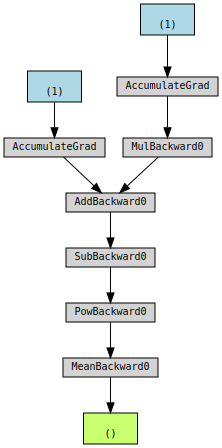

In [32]:
make_dot(loss)

# Optimizer and Loss Function

In [35]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad = True, dtype = torch.float, device = gpu)
b = torch.randn(1, requires_grad = True, dtype = torch.float, device = gpu)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr = lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()

    # No more manual update!
    optimizer.step()

    # No need to tell PyTorch to let gradients go
    optimizer.zero_grad()

print(a, b)

tensor([0.3367], device='privateuseone:0', requires_grad=True) tensor([0.1288], device='privateuseone:0', requires_grad=True)
tensor([1.0235], device='privateuseone:0', requires_grad=True) tensor([1.9690], device='privateuseone:0', requires_grad=True)


In [36]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad = True, dtype = torch.float, device = gpu)
b = torch.randn(1, requires_grad = True, dtype = torch.float, device = gpu)
print(a, b)

lr = 1e-1
n_epochs = 1000

optimizer = optim.SGD([a, b], lr = lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction = 'mean')

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor

    # No more manual loss!
    loss = loss_fn(y_train_tensor, yhat)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print(a, b)

tensor([0.3367], device='privateuseone:0', requires_grad=True) tensor([0.1288], device='privateuseone:0', requires_grad=True)
tensor([1.0235], device='privateuseone:0', requires_grad=True) tensor([1.9690], device='privateuseone:0', requires_grad=True)


## Model Class

In [38]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make a and b real parameters, we need to wrap them in nn.Parameter()
        self.a = nn.Parameter(torch.randn(1, requires_grad = True, dtype = torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad = True, dtype = torch.float))

    def forward(self, x):
        # Computes outputs / predictions
        return self.a + self.b * x

In [40]:
torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(gpu)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction = 'mean')
optimizer = optim.SGD(model.parameters(), lr = lr)

for epoch in range(n_epochs):
    model.train()
    
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print(model.state_dict())

OrderedDict([('a', tensor([0.3367], device='privateuseone:0')), ('b', tensor([0.1288], device='privateuseone:0'))])
OrderedDict([('a', tensor([1.0235], device='privateuseone:0')), ('b', tensor([1.9690], device='privateuseone:0'))])


In [41]:
class LayerLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

In [43]:
model = nn.Sequential(nn.Linear(1, 1)).to(gpu)

In [45]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

train_step = make_train_step(model, loss_fn, optimizer)
losses = []

for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)

# Check model's params
print(model.state_dict())

OrderedDict([('0.weight', tensor([[-0.4869]], device='privateuseone:0')), ('0.bias', tensor([0.5873], device='privateuseone:0'))])
